<a href="https://colab.research.google.com/github/shh2003/Machine-Learning/blob/main/week07/pulseDB_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# =========================================================
# PulseDB/유사 구조 MAT 파일: PPG/ECG 세그먼트로 SBP/DBP 회귀
# - 전구간을 시간순으로 5등분(오버랩 없음)
# - 각 구간에서 320(train) / 40(val) / 40(test) 순서대로 사용
# - 2000 세그먼트 초과는 무시
# - 모델 2종: (1) PPG-only, (2) ECG+PPG(채널 2개)
# - Fold별 MAE/RMSE 출력, 전체 평균/표준편차 출력
# =========================================================
import h5py, numpy as np, math, os, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [16]:
def load_and_display_bp(mat_path, segment_limit=None):
    """
    MAT 파일에서 PPG 세그먼트와 혈압(SBP, DBP) 데이터를 로드하고 표시

    Args:
        mat_path: .mat 파일 경로
        segment_limit: 로드할 최대 세그먼트 수 (None이면 전체)
    """
    segments, sbp_list, dbp_list = [], [], []

    # MAT 파일 로드
    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']['PPG_F'][0]
        sbps = f['Subj_Wins']['SegSBP'][0]
        dbps = f['Subj_Wins']['SegDBP'][0]

        total = min(len(refs), segment_limit) if segment_limit else len(refs)

        print(f"총 {total}개의 세그먼트 로드 중...")

        for i in range(total):
            ppg = f[refs[i]][()].squeeze().astype(np.float32)
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments.append(ppg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    # 통계 출력
    print(f"\n=== 혈압 데이터 통계 ===")
    print(f"세그먼트 수: {len(segments)}")
    print(f"\nSBP (수축기 혈압):")
    print(f"  - 평균: {np.mean(sbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(sbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(sbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(sbp_list):.2f} mmHg")

    print(f"\nDBP (이완기 혈압):")
    print(f"  - 평균: {np.mean(dbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(dbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(dbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(dbp_list):.2f} mmHg")

    # 시각화
    plot_bp_combined_timeseries(sbp_list, dbp_list)

    return segments, sbp_list, dbp_list


In [7]:
def plot_bp_distribution(sbp_list, dbp_list):
    """혈압 분포 히스토그램"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(sbp_list, bins=30, color='red', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('SBP (mmHg)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('SBP Distribution')
    ax1.axvline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.hist(dbp_list, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('DBP (mmHg)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('DBP Distribution')
    ax2.axvline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [8]:
def plot_bp_scatter(sbp_list, dbp_list):
    """SBP vs DBP 산점도"""
    plt.figure(figsize=(8, 6))
    plt.scatter(sbp_list, dbp_list, alpha=0.6, s=50, c=range(len(sbp_list)),
                cmap='viridis', edgecolors='black', linewidth=0.5)

    plt.xlabel('SBP (mmHg)', fontsize=12)
    plt.ylabel('DBP (mmHg)', fontsize=12)
    plt.title('SBP vs DBP Relationship', fontsize=14)
    plt.colorbar(label='Sample Index')
    plt.grid(alpha=0.3)

    # 추세선
    z = np.polyfit(sbp_list, dbp_list, 1)
    p = np.poly1d(z)
    plt.plot(sorted(sbp_list), p(sorted(sbp_list)), "r--",
             linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def plot_bp_timeseries(sbp_list, dbp_list):
    """시간 순서에 따른 SBP/DBP 변화 그래프"""
    time_idx = np.arange(len(sbp_list))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # SBP 시계열
    ax1.plot(time_idx, sbp_list, color='red', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='SBP')
    ax1.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.fill_between(time_idx, sbp_list, alpha=0.2, color='red')
    ax1.set_ylabel('SBP (mmHg)', fontsize=12, fontweight='bold')
    ax1.set_title('Systolic Blood Pressure Over Time', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)

    # DBP 시계열
    ax2.plot(time_idx, dbp_list, color='blue', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='DBP')
    ax2.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.fill_between(time_idx, dbp_list, alpha=0.2, color='blue')
    ax2.set_xlabel('Sample Index (Time Sequence)', fontsize=12)
    ax2.set_ylabel('DBP (mmHg)', fontsize=12, fontweight='bold')
    ax2.set_title('Diastolic Blood Pressure Over Time', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [10]:
def plot_bp_combined_timeseries(sbp_list, dbp_list):
    """SBP와 DBP를 하나의 그래프에 표시 (흰색 배경)"""
    time_idx = np.arange(len(sbp_list))

    fig = plt.figure(figsize=(14, 6), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')

    # SBP와 DBP 라인 플롯
    ax.plot(time_idx, sbp_list, color='red', linewidth=2,
            marker='o', markersize=4, alpha=0.8, label='SBP (Systolic)')
    ax.plot(time_idx, dbp_list, color='blue', linewidth=2,
            marker='s', markersize=4, alpha=0.8, label='DBP (Diastolic)')

    # 평균선
    ax.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'SBP Mean: {np.mean(sbp_list):.1f} mmHg')
    ax.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'DBP Mean: {np.mean(dbp_list):.1f} mmHg')

    # 영역 채우기 (맥압 표시)
    ax.fill_between(time_idx, sbp_list, dbp_list, alpha=0.15, color='purple',
                    label='Pulse Pressure')

    ax.set_xlabel('Sample Index (Time Sequence)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Blood Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Pressure Variation Over Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # 배경색 명시적으로 흰색 설정
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()

In [11]:
def plot_sample_ppg_with_bp(segments, sbp_list, dbp_list, n_samples=5):
    """샘플 PPG 신호와 혈압 값 표시"""
    n = min(n_samples, len(segments))
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))

    if n == 1:
        axes = [axes]

    for i in range(n):
        ppg = segments[i]
        sbp = sbp_list[i]
        dbp = dbp_list[i]

        axes[i].plot(ppg, color='black', linewidth=1.2)
        axes[i].set_title(f'Sample {i+1} | SBP: {sbp:.1f} mmHg | DBP: {dbp:.1f} mmHg',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('PPG Amplitude')
        axes[i].grid(alpha=0.3)

        # 혈압 정보를 텍스트로 추가
        axes[i].text(0.02, 0.95, f'SBP: {sbp:.1f}\nDBP: {dbp:.1f}',
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


총 2000개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 2000

SBP (수축기 혈압):
  - 평균: 138.76 mmHg
  - 최소: 121.88 mmHg
  - 최대: 156.40 mmHg
  - 표준편차: 6.84 mmHg

DBP (이완기 혈압):
  - 평균: 70.24 mmHg
  - 최소: 58.36 mmHg
  - 최대: 88.74 mmHg
  - 표준편차: 5.73 mmHg


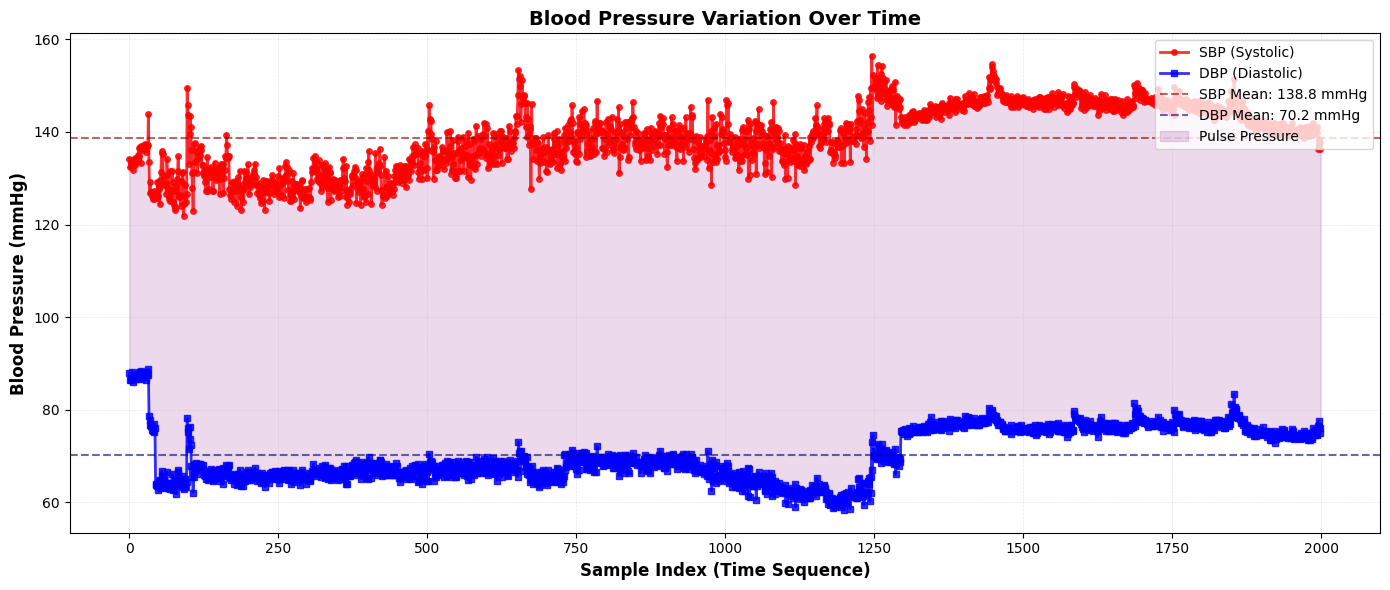


로드 완료: 2000개의 PPG 세그먼트


In [13]:
# ============ 실행 예제 ============
if __name__ == '__main__':
    # 파일 경로 설정
    MAT_FILE = "/content/drive/MyDrive/Colab Notebooks/p_file/p061207.mat"

    # 데이터 로드 및 표시 (500개 세그먼트만)
    segments, sbp_values, dbp_values = load_and_display_bp(
        mat_path=MAT_FILE,
        segment_limit=2000
    )

    print(f"\n로드 완료: {len(segments)}개의 PPG 세그먼트")